In [1]:
import os
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F  # Import F module
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data using polars
directory = r'D:\github\Cricket-Prediction\data\filteredData'
balltoball = pl.read_csv(os.path.join(directory, 'balltoball.csv'))
teamStats = pl.read_csv(os.path.join(directory, 'team12Stats.csv'))
playersStats = pl.read_csv(os.path.join(directory, 'playersStats.csv'))

# Preprocess the data
def partition_data(df, group_keys):
    partitions = df.partition_by(group_keys)
    partition_list = [partition.drop(group_keys).to_numpy() for partition in partitions]
    return partition_list

team_stats_partitions = partition_data(teamStats, ['match_id', 'flip'])
player_stats_partitions = partition_data(playersStats, ['match_id', 'flip'])
ball_stats_partitions = partition_data(balltoball, ['match_id', 'flip'])

# Augment the data by creating new samples with different combinations of overs
def augment_data(team_stats_list, player_stats_list, ball_stats_list, over_segments=np.arange(6, 20, 1)):
    augmented_team_stats = []
    augmented_player_stats = []
    augmented_ball_stats = []
    
    for team_stats, player_stats, ball_stats in zip(team_stats_list, player_stats_list, ball_stats_list):
        total_overs = ball_stats.shape[0] // 6  # Assuming 6 balls per over
        for segment in over_segments:
            if total_overs >= segment:
                end_idx = segment * 6
                augmented_team_stats.append(team_stats)
                augmented_player_stats.append(player_stats)
                augmented_ball_stats.append(ball_stats[:end_idx])
    
    return augmented_team_stats, augmented_player_stats, augmented_ball_stats

augmented_team_stats, augmented_player_stats, augmented_ball_stats = augment_data(
    team_stats_partitions, player_stats_partitions, ball_stats_partitions)

# Split the dataset into training and validation sets
train_team_stats, val_team_stats, train_player_stats, val_player_stats, train_ball_stats, val_ball_stats = train_test_split(
    augmented_team_stats, augmented_player_stats, augmented_ball_stats, test_size=0.2, random_state=42)

In [2]:
# Create a custom Dataset
class CricketDataset(Dataset):
    def __init__(self, team_stats_list, player_stats_list, ball_stats_list):
        self.team_stats_list = team_stats_list
        self.player_stats_list = player_stats_list
        self.ball_stats_list = ball_stats_list

    def __len__(self):
        return len(self.team_stats_list)

    def __getitem__(self, idx):
        team_input = torch.tensor(self.team_stats_list[idx], dtype=torch.float32)
        team_input = team_input.squeeze()  # Remove extra dimensions
        player_input = torch.tensor(self.player_stats_list[idx], dtype=torch.float32)
        ball_stats = torch.tensor(self.ball_stats_list[idx], dtype=torch.float32)
        # Assuming the last column is the label
        ball_input = ball_stats[:, :-1]
        label = ball_stats[0, -1]
        return team_input, player_input, ball_input, label

# Define a collate function to handle variable-length sequences
def collate_fn(batch):
    team_inputs = []
    player_inputs = []
    ball_inputs = []
    labels = []
    ball_lengths = []

    for team_input, player_input, ball_input, label in batch:
        team_inputs.append(team_input)
        player_inputs.append(player_input)
        ball_inputs.append(ball_input)
        labels.append(label)
        ball_lengths.append(ball_input.shape[0])

    # Pad ball_inputs to the maximum sequence length in the batch
    max_seq_len = max(ball_lengths)
    padded_ball_inputs = torch.zeros(len(ball_inputs), max_seq_len, ball_inputs[0].shape[1])
    for i, ball_input in enumerate(ball_inputs):
        seq_len = ball_input.shape[0]
        padded_ball_inputs[i, :seq_len, :] = ball_input

    team_inputs = torch.stack(team_inputs)
    player_inputs = torch.stack(player_inputs)
    labels = torch.tensor(labels, dtype=torch.float32)
    return team_inputs, player_inputs, padded_ball_inputs, labels, ball_lengths

# Create the training and validation datasets and dataloaders
train_dataset = CricketDataset(train_team_stats, train_player_stats, train_ball_stats)
val_dataset = CricketDataset(val_team_stats, val_player_stats, val_ball_stats)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [3]:
# Define the models
class TeamStatsModel(nn.Module):
    def __init__(self, input_size):
        super(TeamStatsModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

class PlayerStatsModel(nn.Module):
    def __init__(self, input_size):
        super(PlayerStatsModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * ((input_size - 4) // 4), 16)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch, channels, seq_len)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        return x

class BallToBallModel(nn.Module):
    def __init__(self, input_dim):
        super(BallToBallModel, self).__init__()
        # Transformer is used here to capture both inter-match and intra-match patterns due to its self-attention mechanism.
        self.embedding = nn.Linear(input_dim, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.fc = nn.Linear(128, 16)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Convert to (seq_len, batch, d_model)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Convert back to (batch, seq_len, d_model)
        x = x.mean(dim=1)  # Average pooling over the sequence length
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        return x

class CombinedModel(nn.Module):
    def __init__(self, team_input_size, player_input_size, ball_input_dim):
        super(CombinedModel, self).__init__()
        self.team_model = TeamStatsModel(team_input_size)
        self.player_model = PlayerStatsModel(player_input_size)
        self.ball_model = BallToBallModel(ball_input_dim)
        self.fc = nn.Sequential(
            nn.Linear(16+16+16, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, team_input, player_input, ball_input, ball_lengths):
        team_output = self.team_model(team_input)
        player_output = self.player_model(player_input)
        ball_output = self.ball_model(ball_input, ball_lengths)
        combined = torch.cat((team_output, player_output, ball_output), dim=1)
        output = self.fc(combined)
        return output.squeeze()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
team_input_size = team_stats_partitions[0].shape[1]
player_input_size = player_stats_partitions[0].shape[1]
ball_input_dim = ball_stats_partitions[0].shape[1] - 1  # Exclude label

In [4]:
model = CombinedModel(team_input_size, player_input_size, ball_input_dim).to(device)  # Move model to GPU

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Weight decay for regularization
criterion = nn.BCELoss()

# Implement early stopping
best_loss = np.inf
patience = 10
trigger_times = 0

# Training loop with tqdm
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for team_input, player_input, ball_input, labels, ball_lengths in progress_bar:
        team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(team_input, player_input, ball_input, ball_lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        progress_bar.set_postfix(loss=loss.item())
    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for team_input, player_input, ball_input, labels, ball_lengths in val_dataloader:
            team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)  # Move data to GPU
            outputs = model(team_input, player_input, ball_input, ball_lengths)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            val_correct_predictions += (predictions == labels).sum().item()
            val_total_predictions += labels.size(0)
    avg_val_loss = val_running_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        trigger_times = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

c:\Users\chavv\anaconda\envs\huggingface-torch\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/50:   0%|          | 0/1613 [00:00<?, ?it/s]c:\Users\chavv\anaconda\envs\huggingface-torch\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1/50:  72%|███████▏  | 1162/1613 [00:56<00:21, 20.65it/s, loss=0.697]


KeyboardInterrupt: 

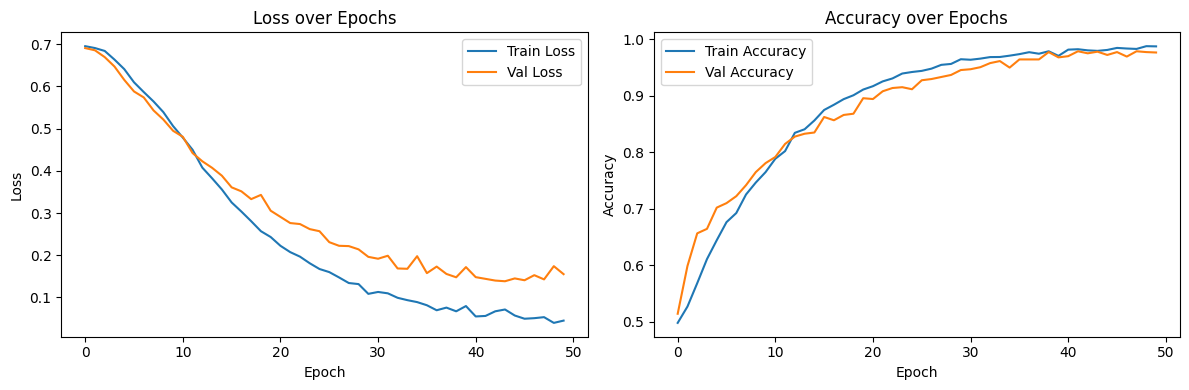

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.savefig('training_validation_history.png')
plt.show()

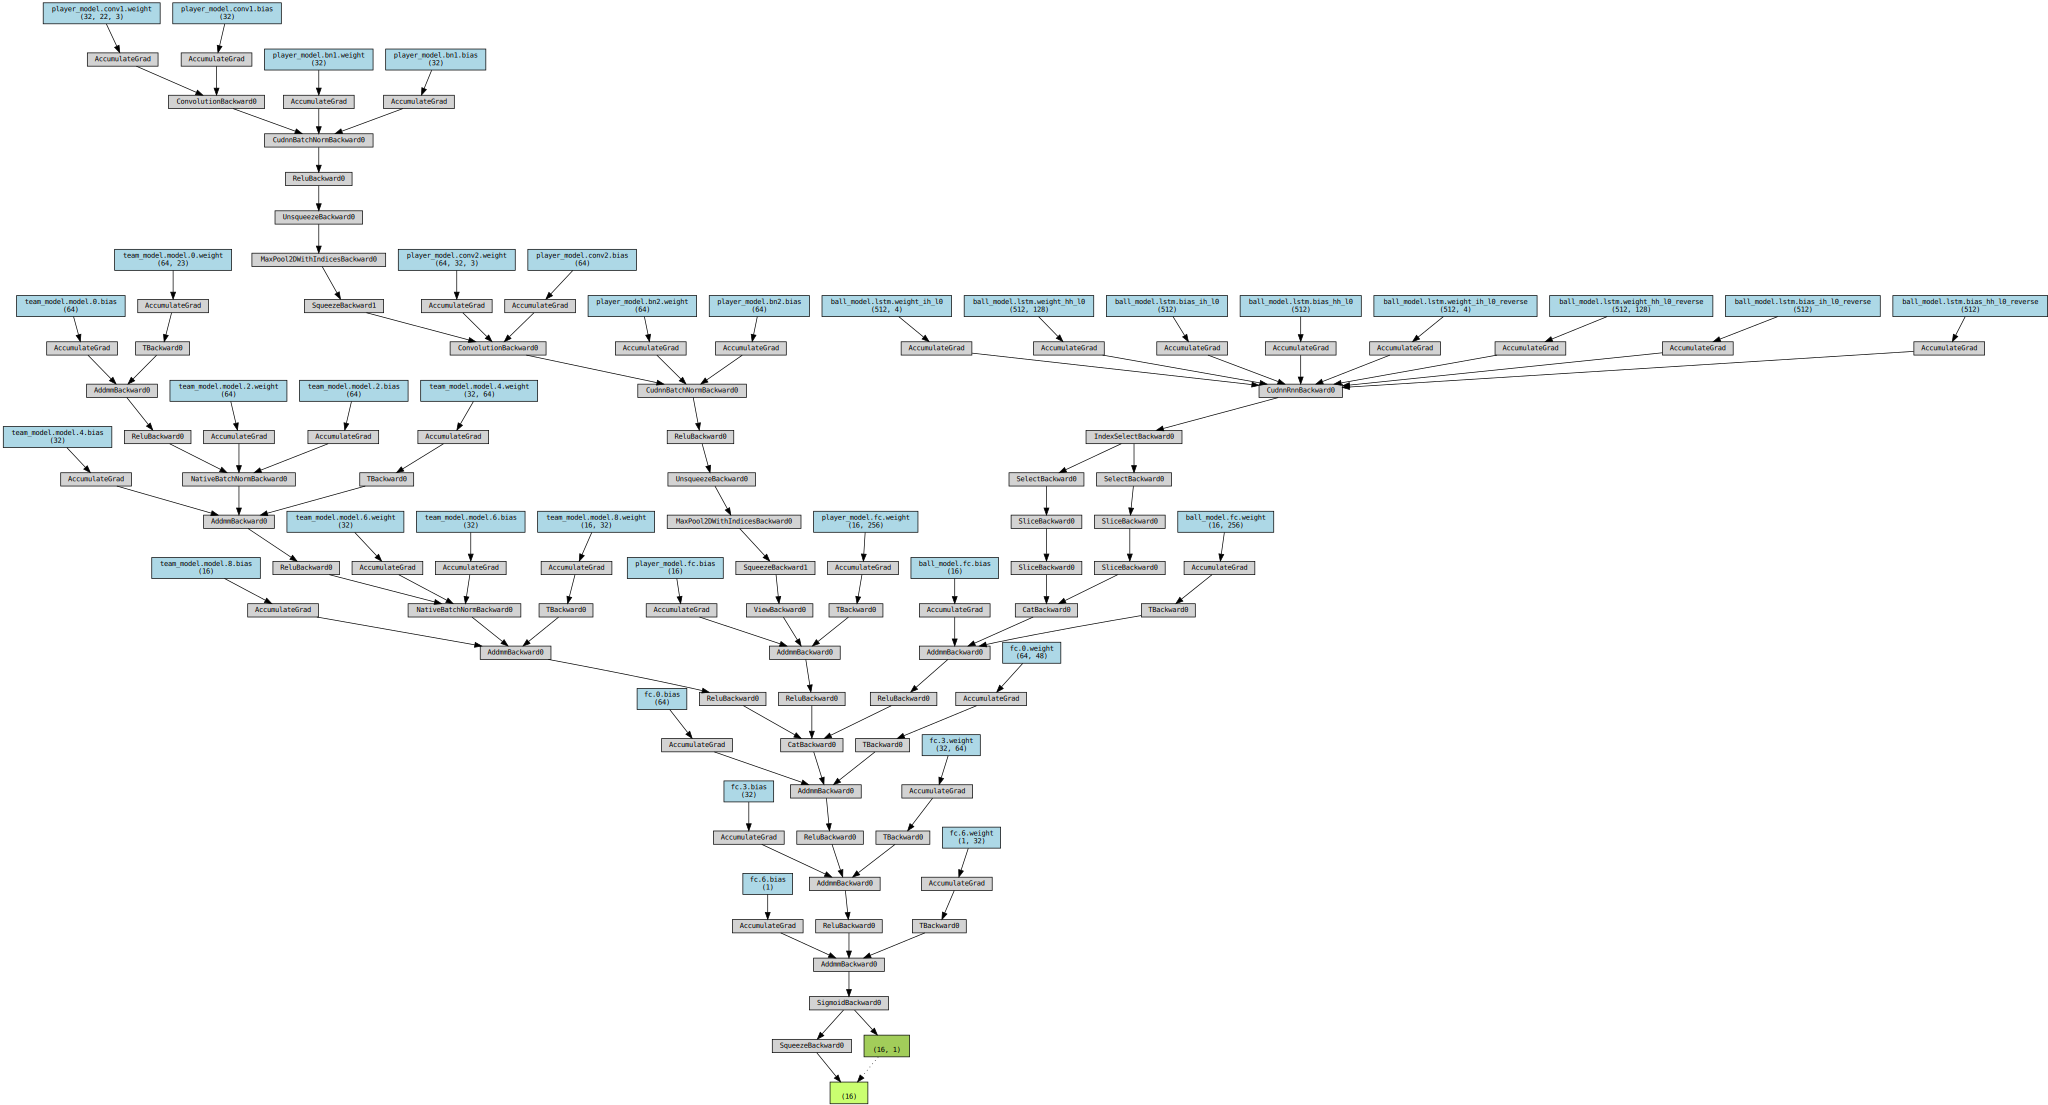

In [ ]:
# plot model architecture
from torchviz import make_dot
team_input = torch.randn(16, 23).to(device)
player_input = torch.randn(16, 22, 22).to(device)  # Adjusted to match the input size of PlayerStatsModel
ball_input = torch.randn(16, 36, 4).to(device)
ball_lengths = [36] * 16
model.eval()
out = model(team_input, player_input, ball_input, ball_lengths)

# Visualize the model
make_dot(out, params=dict(model.named_parameters()))